In [1]:
import numpy as np 
import pandas as pd 
import os
import random
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
import sklearn
from sklearn import metrics
import seaborn as sns
from tensorflow.keras import layers, models 



## Data Input & EDA

In [2]:
train_path = 'train'
test_path = 'test'
max_size = 50
learning_rate = 1e-3

def label_img(img):
    animal_label = img.split('.')
    if animal_label[0] == 'cat': 
        return [1,0]
    elif animal_label[0] == 'dog': 
        return [0,1]
    
def create_train_data():
    training_data = []
    labels = []
    i = 0
    for img in tqdm(os.listdir(train_path)):
        label = label_img(img)
        path = os.path.join(train_path,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (max_size,max_size))[:, :, ::-1]
        training_data.append(np.array(img))
        labels.append(np.array(label))
    print("Created Training Data")
    return np.array(training_data), np.array(labels)

def create_test_data():
    testing_data = []
    ids = []
    i = 0
    for img in tqdm(os.listdir(test_path)):
        path = os.path.join(test_path,img)
        test_id = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (max_size,max_size))
        testing_data.append(np.array(img))
        ids.append(np.array(test_id))
    print("Created Testing Data")
    return np.array(testing_data), np.array(ids)


In [3]:
data, labels = create_train_data()
data = data / 255 

100%|████████████████████████████████████| 25000/25000 [01:07<00:00, 372.31it/s]


Created Training Data


In [4]:
test_data, test_ids = create_test_data()
test_data = test_data / 255 

100%|████████████████████████████████████| 12500/12500 [00:35<00:00, 355.85it/s]


Created Testing Data


In [5]:
def PrintRandomPic():
    plt.imshow(data[random.randint(0, 25000)])


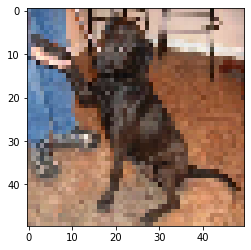

In [6]:
PrintRandomPic()

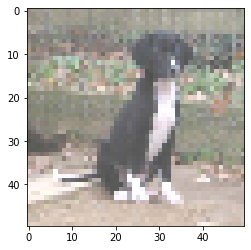

In [7]:
PrintRandomPic()

Images quality are good enough to do analysis and not be labor intensive, going to split the data next

In [8]:
modified_split_70 = int(0.7 * data.shape[0])
modified_split_30 = int(0.3 * data.shape[0])

X_train, X_test, X_valid = \
tf.split(data, num_or_size_splits = \
         [modified_split_70, 0, modified_split_30], axis=0)
y_train, y_test, y_valid = \
tf.split(labels, [modified_split_70, 0, modified_split_30], axis=0 )

2021-11-13 14:15:55.423125: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Helper Functions

In [9]:
def evaluateModel(model, X_valid, y_valid):
    print(model.evaluate(X_valid, y_valid))
    

In [10]:
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn')
]

In [49]:
def plot_metrics_values(history):
    metrics =  ['auc', 'precision', 'recall']
    plt.figure(figsize=(15, 15))
    for n, metric in enumerate(metrics):
        name = metric
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  
                 history.history[metric], color= 'g', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color= 'r', linestyle="--", label='Val')
        plt.title(name, fontsize=20)
        plt.xlabel('Epoch', fontsize=15)
        plt.ylabel(name, fontsize=15)
        
        if metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
        plt.legend()


In [12]:
def plot_roc_curve(model):
    
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_valid)
    fp_train, tp_train, _ = 
    metrics.roc_curve(y_train[:, 0].numpy(), train_predict)
    fp_valid, tp_valid, _ = 
    metrics.roc_curve( y_valid[:, 0].numpy(), test_predict)
    
    plt.subplot(2,2)

    plt.plot(100*fp_train, 100*tp_train, label = "Train Baseline", 
             linewidth=2, color ='b')
    plt.plot(100*fp_valid, 100*tp_valid, label = "Test Baseline", 
             linewidth=2,  color = 'r', linestyle = '--')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.legend(loc = 'lower right')
    



## Model #1

In [14]:
def buildNaiveCNNModel(input_shape):
    model_1 = models.Sequential()
    model_1.add(layers.Conv2D(32, (3, 3), activation = 'relu', 
                              input_shape = input_shape))
    model_1.add(layers.MaxPool2D((2, 2)))
    model_1.add(layers.Flatten())
    model_1.add(layers.Dense(64, activation = 'relu'))
    model_1.add(layers.Dense(2, activation = 'softmax'))
    
    return model_1


In [15]:
(_, data_length, data_width, _) = data.shape
input_shape = (data_length, data_width, 3)
model_1 = buildNaiveCNNModel(input_shape)

In [16]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 64)                1179712   
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1,180,738
Trainable params: 1,180,738
Non-trainable params: 0
______________________________________________

In [17]:
model_1.compile(optimizer = 'adam',
              loss = tf.keras.losses.binary_crossentropy,
              metrics = METRICS)

In [19]:
history_naive = model_1.fit(X_train, y_train, epochs = 10, 
                    batch_size = 1000, shuffle = True,
                    validation_data = (X_valid, y_valid)
                   )

Epoch 1/10
18/18 [==============================] - 31s 1s/step - loss: 0.7448 - accuracy: 0.5298 - auc: 0.5191 - precision: 0.5298 - recall: 0.5298 - tp: 9272.0000 - fp: 8228.0000 - tn: 9272.0000 - fn: 8228.0000 - val_loss: 0.6851 - val_accuracy: 0.6248 - val_auc: 0.6753 - val_precision: 0.6248 - val_recall: 0.6248 - val_tp: 4686.0000 - val_fp: 2814.0000 - val_tn: 4686.0000 - val_fn: 2814.0000
Epoch 2/10
18/18 [==============================] - 21s 1s/step - loss: 0.6803 - accuracy: 0.6355 - auc: 0.6864 - precision: 0.6355 - recall: 0.6355 - tp: 11121.0000 - fp: 6379.0000 - tn: 11121.0000 - fn: 6379.0000 - val_loss: 0.6730 - val_accuracy: 0.6651 - val_auc: 0.7268 - val_precision: 0.6651 - val_recall: 0.6651 - val_tp: 4988.0000 - val_fp: 2512.0000 - val_tn: 4988.0000 - val_fn: 2512.0000
Epoch 3/10
18/18 [==============================] - 20s 1s/step - loss: 0.6655 - accuracy: 0.6761 - auc: 0.7377 - precision: 0.6761 - recall: 0.6761 - tp: 11832.0000 - fp: 5668.0000 - tn: 11832.0000 - f

In [20]:
evaluateModel(model_1, X_valid, y_valid)

235/235 [==============================] - 3s 13ms/step - loss: 0.5560 - accuracy: 0.7313 - auc: 0.8084 - precision: 0.7313 - recall: 0.7313 - tp: 5485.0000 - fp: 2015.0000 - tn: 5485.0000 - fn: 2015.0000
[0.5559983253479004, 0.731333315372467, 0.8083864450454712, 0.731333315372467, 0.731333315372467, 5485.0, 2015.0, 5485.0, 2015.0]


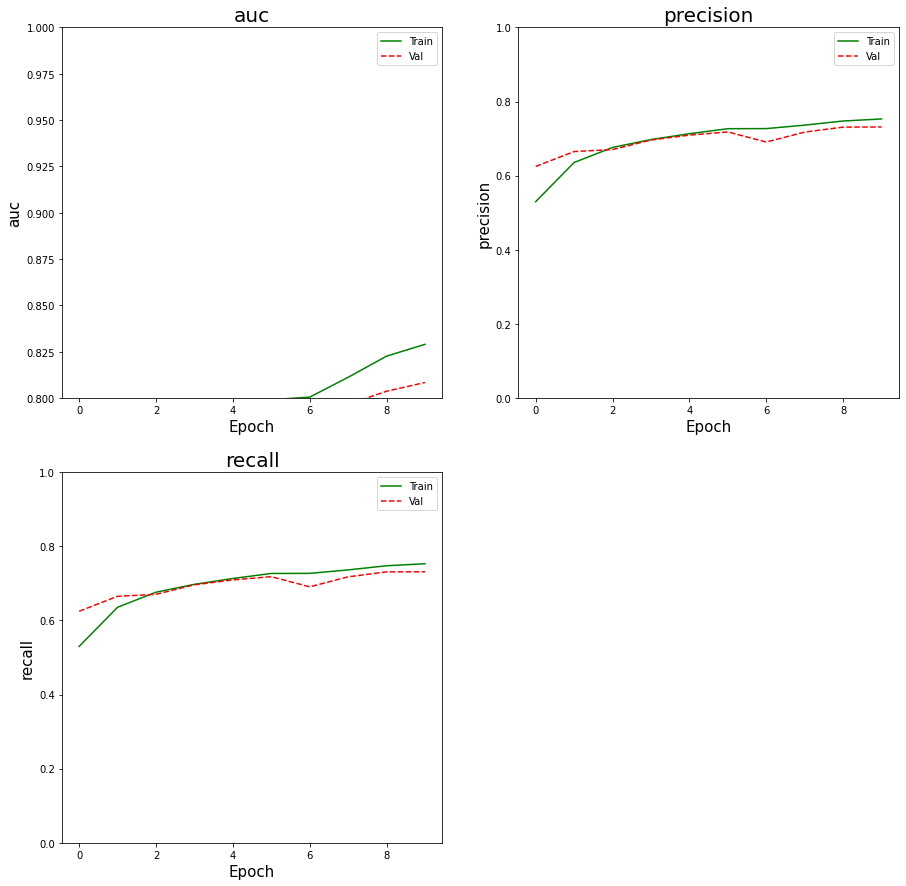

In [50]:
plot_metrics_values(history_naive)

In [57]:
train_predict = model_1.predict(X_train)
test_predict = model_1.predict(X_valid)
# plot_roc_curve(model_1)

The AUC curve is not indicating a strong model. Additionally, the accuracy metrics is not that great in comparison to previous models used in earlier assignments. The other goodness of fit metrics such as precision and recall do not indicate a strong model as well. More work needs to be done

In [23]:
results = model_1.predict(test_data)
results = results[:, 1] / np.sum(results, axis = 1)
submission = pd.concat([pd.Series(test_ids), pd.Series(results)], axis = 1)

In [24]:
submission_naive = submission.rename(columns = {0: 'id', 1: 'label'})
submission_naive.head()

,id,label
0,9733,0.048437
1,63,0.532536
2,6400,0.806057
3,823,0.983393
4,4217,0.875969


In [25]:
submission_naive.to_csv('model_1.csv', index = False)

## Model #2

Added more layers to the model, as well as added more Epochs (15) as I believe this will help create a stronger model

In [26]:
def buildModerateCNNmodel(input_shape):
    model_2 = models.Sequential()
    model_2.add(layers.Conv2D(32, (3, 3), activation = 'relu', 
                              input_shape = input_shape))
    model_2.add(layers.MaxPool2D((2, 2)))
    model_2.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
    model_2.add(layers.MaxPool2D((2, 2)))
    model_2.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
    model_2.add(layers.Flatten())
    model_2.add(layers.Dense(64, activation = 'relu'))
    model_2.add(layers.Dense(2, activation = 'softmax'))

    return model_2

In [27]:
(_, data_length, data_width, _) = data.shape
input_shape = (data_length, data_width, 3)
model_2 = buildModerateCNNmodel(input_shape)
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 5184)             

In [28]:
model_2.compile(optimizer = 'adam',
              loss = tf.keras.losses.binary_crossentropy,
              metrics = METRICS)

In [29]:
history_moderate = model_2.fit(X_train, y_train, epochs = 15, 
    batch_size = 1000, shuffle = True, validation_data = (X_valid, y_valid))


Epoch 1/15
18/18 [==============================] - 57s 3s/step - loss: 0.6962 - accuracy: 0.5821 - auc: 0.6355 - precision: 0.5821 - recall: 0.5821 - tp: 14553.0000 - fp: 10447.0000 - tn: 14553.0000 - fn: 10447.0000 - val_loss: 0.6817 - val_accuracy: 0.5893 - val_auc: 0.6293 - val_precision: 0.5893 - val_recall: 0.5893 - val_tp: 4420.0000 - val_fp: 3080.0000 - val_tn: 4420.0000 - val_fn: 3080.0000
Epoch 2/15
18/18 [==============================] - 42s 2s/step - loss: 0.6705 - accuracy: 0.5881 - auc: 0.6260 - precision: 0.5881 - recall: 0.5881 - tp: 10292.0000 - fp: 7208.0000 - tn: 10292.0000 - fn: 7208.0000 - val_loss: 0.6451 - val_accuracy: 0.6375 - val_auc: 0.6909 - val_precision: 0.6375 - val_recall: 0.6375 - val_tp: 4781.0000 - val_fp: 2719.0000 - val_tn: 4781.0000 - val_fn: 2719.0000
Epoch 3/15
18/18 [==============================] - 40s 2s/step - loss: 0.6284 - accuracy: 0.6456 - auc: 0.7021 - precision: 0.6456 - recall: 0.6456 - tp: 11298.0000 - fp: 6202.0000 - tn: 11298.0000

In [30]:
evaluateModel(model_2, X_valid, y_valid)

235/235 [==============================] - 5s 20ms/step - loss: 0.4254 - accuracy: 0.8104 - auc: 0.8868 - precision: 0.8104 - recall: 0.8104 - tp: 6078.0000 - fp: 1422.0000 - tn: 6078.0000 - fn: 1422.0000
[0.4254029095172882, 0.8104000091552734, 0.8868176341056824, 0.8104000091552734, 0.8104000091552734, 6078.0, 1422.0, 6078.0, 1422.0]


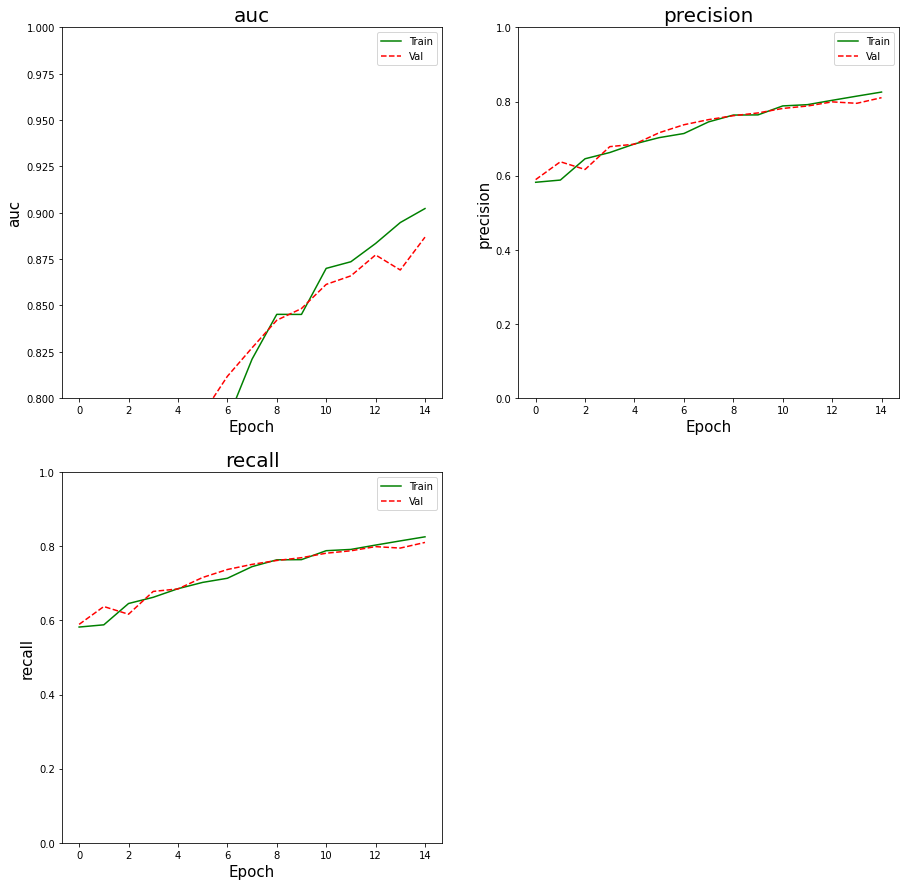

In [51]:
plot_metrics_values(history_moderate)
# plot_roc_curve(model_2)

Recall, auc, and precision curves are showcasing a good robust model. The accuracy is great enough where the model is actually predicting correctly. I hope more epochs help the model even further as running the whole dataset is time consuming. 

In [34]:
results = model_2.predict(test_data)
results = results[:, 1] / np.sum(results, axis = 1)
submission = pd.concat([pd.Series(test_ids), pd.Series(results)], axis = 1)

In [35]:
submission_moderate = submission.rename(columns = {0: 'id', 1: 'label'})
submission_moderate.head()

,id,label
0,9733,0.045972
1,63,0.089834
2,6400,0.961624
3,823,0.999499
4,4217,0.190981


In [36]:
submission_moderate.to_csv('model_2.csv', index = False)

## Model #3 (More Epochs!)

In [37]:
def buildRobustCNNmodel(input_shape):

    model_3 = models.Sequential()
    model_3.add(layers.Conv2D(32, (3, 3), activation = 'relu', 
                              input_shape = input_shape))
    model_3.add(layers.MaxPool2D((2, 2)))
    model_3.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
    model_3.add(layers.MaxPool2D((2, 2)))
    model_3.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
    model_3.add(layers.Flatten())
    model_3.add(layers.Dense(64, activation = 'relu'))
    model_3.add(layers.Dense(2, activation = 'softmax'))

    return model_3

In [38]:
(_, data_length, data_width, _) = data.shape
input_shape = (data_length, data_width, 3)
model_3 = buildRobustCNNmodel(input_shape)


In [39]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 5184)             

In [40]:
model_3.compile(optimizer = 'adam',
              loss = tf.keras.losses.binary_crossentropy,
              metrics = METRICS)

In [41]:
history_robust = model_3.fit(X_train, y_train, epochs = 23, 
                    batch_size = 1000, shuffle = True,
                    validation_data = (X_valid, y_valid)
                   )


Epoch 1/23
18/18 [==============================] - 73s 4s/step - loss: 0.6887 - accuracy: 0.6208 - auc: 0.7005 - precision: 0.6208 - recall: 0.6208 - tp: 15520.0000 - fp: 9480.0000 - tn: 15520.0000 - fn: 9480.0000 - val_loss: 0.6619 - val_accuracy: 0.6441 - val_auc: 0.7002 - val_precision: 0.6441 - val_recall: 0.6441 - val_tp: 4831.0000 - val_fp: 2669.0000 - val_tn: 4831.0000 - val_fn: 2669.0000
Epoch 2/23
18/18 [==============================] - 83s 4s/step - loss: 0.6634 - accuracy: 0.5960 - auc: 0.6373 - precision: 0.5960 - recall: 0.5960 - tp: 10430.0000 - fp: 7070.0000 - tn: 10430.0000 - fn: 7070.0000 - val_loss: 0.6344 - val_accuracy: 0.6519 - val_auc: 0.7099 - val_precision: 0.6519 - val_recall: 0.6519 - val_tp: 4889.0000 - val_fp: 2611.0000 - val_tn: 4889.0000 - val_fn: 2611.0000
Epoch 3/23
18/18 [==============================] - 50s 3s/step - loss: 0.6191 - accuracy: 0.6602 - auc: 0.7163 - precision: 0.6602 - recall: 0.6602 - tp: 11554.0000 - fp: 5946.0000 - tn: 11554.0000 -

In [42]:
evaluateModel(model_3, X_valid, y_valid)

235/235 [==============================] - 5s 20ms/step - loss: 0.4127 - accuracy: 0.8141 - auc: 0.8927 - precision: 0.8141 - recall: 0.8141 - tp: 6106.0000 - fp: 1394.0000 - tn: 6106.0000 - fn: 1394.0000
[0.41271695494651794, 0.81413334608078, 0.8926693797111511, 0.81413334608078, 0.81413334608078, 6106.0, 1394.0, 6106.0, 1394.0]


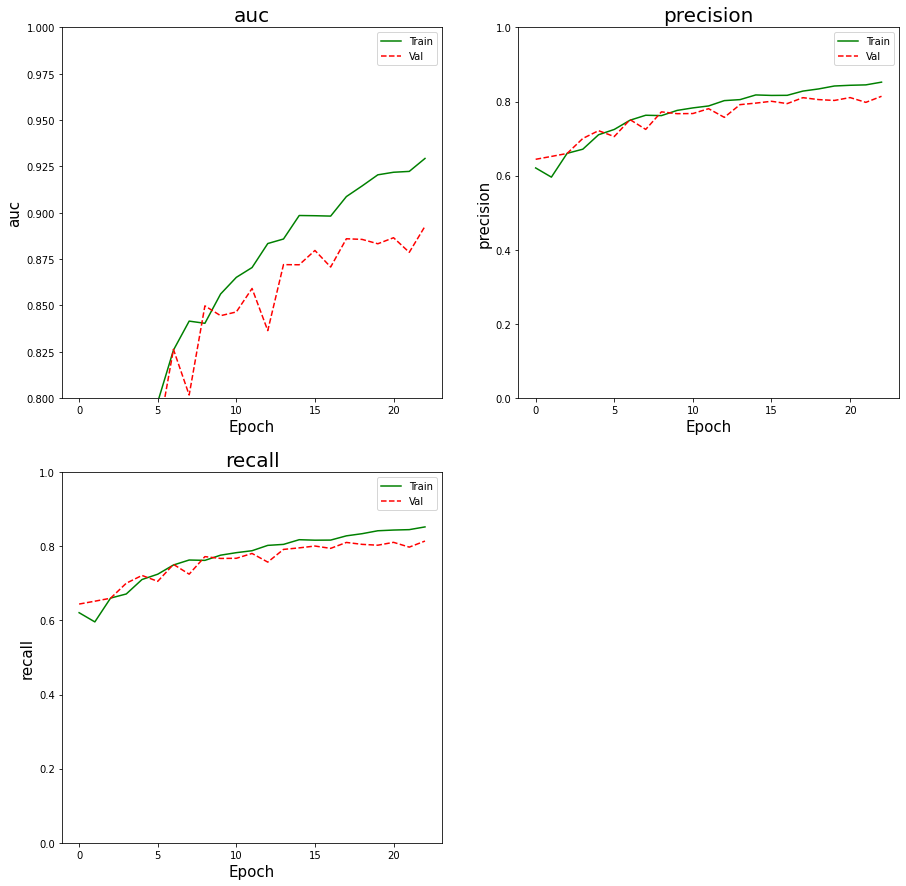

In [52]:
plot_metrics_values(history_robust)
# plot_roc_curve(model_3)

Very interesting to note that the area under the curve graph fared worse here while accuracy and other metrics are comparable to the previous models. Not much has changed when it came to the auc curve thus the epochs did not add much value. It could have started to overfit the model. 

In [45]:
results = model_3.predict(test_data)
results = results[:, 1] / np.sum(results, axis = 1)
submission = pd.concat([pd.Series(test_ids), pd.Series(results)], axis = 1)

In [46]:
submission = submission.rename(columns = {0: 'id', 1: 'label'})
submission.head()

,id,label
0,9733,0.075848
1,63,0.521583
2,6400,0.779092
3,823,0.999953
4,4217,0.157039


In [47]:
submission.to_csv('model_3.csv', index = False)